### Embeddingレイヤの実装

In [1]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        np.add.at(dW, self.idx, dout)
        # or below
        # for i, word_id in enumerate(self.idx):
        #     dW[word_id] += dout[i]
            
        return None

### 多値分類から二値分類へ

In [2]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### Negative Samplingのサンプリング手法

In [3]:
import collections

In [4]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)

        return negative_sample

### Negative Samplingの実装

In [5]:
from common.layers import Embedding, SigmoidWithLoss

In [6]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

### CBOWモデルの実装

In [7]:
from common.layers import Embedding

In [8]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def  forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### CBOWモデルの学習コード

In [9]:
import pickle
from common import config
from common.trainer import Trainer
from common. optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [10]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

In [11]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

In [12]:
contexts, target = create_contexts_target(corpus, window_size)

In [13]:
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 3[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 4[s] | loss 4.13
| epoch 1 |  iter 81 / 9295 | time 6[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 7[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 9[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 10[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 11[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 13[s] | loss 3.36
| epoch 1 |  iter 201 / 9295 | time 14[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 16[s] | loss 3.18
| epoch 1 |  iter 241 / 9295 | time 17[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 19[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 20[s] | loss 2.99
| epoch 1 |  iter 301 / 9295 | time 22[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 23[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 25[s] | loss 2.83
| epoch 1 |  iter 361 / 9295 | time 26[s]

| epoch 1 |  iter 2981 / 9295 | time 219[s] | loss 2.45
| epoch 1 |  iter 3001 / 9295 | time 220[s] | loss 2.42
| epoch 1 |  iter 3021 / 9295 | time 222[s] | loss 2.47
| epoch 1 |  iter 3041 / 9295 | time 223[s] | loss 2.43
| epoch 1 |  iter 3061 / 9295 | time 225[s] | loss 2.46
| epoch 1 |  iter 3081 / 9295 | time 226[s] | loss 2.44
| epoch 1 |  iter 3101 / 9295 | time 228[s] | loss 2.45
| epoch 1 |  iter 3121 / 9295 | time 229[s] | loss 2.43
| epoch 1 |  iter 3141 / 9295 | time 231[s] | loss 2.43
| epoch 1 |  iter 3161 / 9295 | time 232[s] | loss 2.43
| epoch 1 |  iter 3181 / 9295 | time 233[s] | loss 2.46
| epoch 1 |  iter 3201 / 9295 | time 235[s] | loss 2.43
| epoch 1 |  iter 3221 / 9295 | time 236[s] | loss 2.43
| epoch 1 |  iter 3241 / 9295 | time 238[s] | loss 2.43
| epoch 1 |  iter 3261 / 9295 | time 239[s] | loss 2.43
| epoch 1 |  iter 3281 / 9295 | time 241[s] | loss 2.42
| epoch 1 |  iter 3301 / 9295 | time 242[s] | loss 2.46
| epoch 1 |  iter 3321 / 9295 | time 244[s] | lo

| epoch 1 |  iter 5921 / 9295 | time 434[s] | loss 2.33
| epoch 1 |  iter 5941 / 9295 | time 436[s] | loss 2.33
| epoch 1 |  iter 5961 / 9295 | time 437[s] | loss 2.34
| epoch 1 |  iter 5981 / 9295 | time 439[s] | loss 2.34
| epoch 1 |  iter 6001 / 9295 | time 440[s] | loss 2.32
| epoch 1 |  iter 6021 / 9295 | time 442[s] | loss 2.35
| epoch 1 |  iter 6041 / 9295 | time 443[s] | loss 2.34
| epoch 1 |  iter 6061 / 9295 | time 445[s] | loss 2.31
| epoch 1 |  iter 6081 / 9295 | time 446[s] | loss 2.30
| epoch 1 |  iter 6101 / 9295 | time 448[s] | loss 2.34
| epoch 1 |  iter 6121 / 9295 | time 449[s] | loss 2.33
| epoch 1 |  iter 6141 / 9295 | time 451[s] | loss 2.31
| epoch 1 |  iter 6161 / 9295 | time 452[s] | loss 2.31
| epoch 1 |  iter 6181 / 9295 | time 454[s] | loss 2.33
| epoch 1 |  iter 6201 / 9295 | time 455[s] | loss 2.34
| epoch 1 |  iter 6221 / 9295 | time 457[s] | loss 2.33
| epoch 1 |  iter 6241 / 9295 | time 458[s] | loss 2.31
| epoch 1 |  iter 6261 / 9295 | time 459[s] | lo

| epoch 1 |  iter 8861 / 9295 | time 650[s] | loss 2.25
| epoch 1 |  iter 8881 / 9295 | time 652[s] | loss 2.26
| epoch 1 |  iter 8901 / 9295 | time 653[s] | loss 2.22
| epoch 1 |  iter 8921 / 9295 | time 655[s] | loss 2.26
| epoch 1 |  iter 8941 / 9295 | time 656[s] | loss 2.22
| epoch 1 |  iter 8961 / 9295 | time 658[s] | loss 2.25
| epoch 1 |  iter 8981 / 9295 | time 659[s] | loss 2.22
| epoch 1 |  iter 9001 / 9295 | time 661[s] | loss 2.24
| epoch 1 |  iter 9021 / 9295 | time 662[s] | loss 2.24
| epoch 1 |  iter 9041 / 9295 | time 664[s] | loss 2.24
| epoch 1 |  iter 9061 / 9295 | time 665[s] | loss 2.23
| epoch 1 |  iter 9081 / 9295 | time 666[s] | loss 2.24
| epoch 1 |  iter 9101 / 9295 | time 668[s] | loss 2.20
| epoch 1 |  iter 9121 / 9295 | time 669[s] | loss 2.21
| epoch 1 |  iter 9141 / 9295 | time 671[s] | loss 2.22
| epoch 1 |  iter 9161 / 9295 | time 672[s] | loss 2.23
| epoch 1 |  iter 9181 / 9295 | time 674[s] | loss 2.24
| epoch 1 |  iter 9201 / 9295 | time 675[s] | lo

| epoch 2 |  iter 2521 / 9295 | time 868[s] | loss 2.12
| epoch 2 |  iter 2541 / 9295 | time 869[s] | loss 2.11
| epoch 2 |  iter 2561 / 9295 | time 870[s] | loss 2.12
| epoch 2 |  iter 2581 / 9295 | time 872[s] | loss 2.13
| epoch 2 |  iter 2601 / 9295 | time 873[s] | loss 2.12
| epoch 2 |  iter 2621 / 9295 | time 875[s] | loss 2.17
| epoch 2 |  iter 2641 / 9295 | time 876[s] | loss 2.11
| epoch 2 |  iter 2661 / 9295 | time 878[s] | loss 2.13
| epoch 2 |  iter 2681 / 9295 | time 879[s] | loss 2.14
| epoch 2 |  iter 2701 / 9295 | time 881[s] | loss 2.13
| epoch 2 |  iter 2721 / 9295 | time 882[s] | loss 2.14
| epoch 2 |  iter 2741 / 9295 | time 884[s] | loss 2.09
| epoch 2 |  iter 2761 / 9295 | time 885[s] | loss 2.12
| epoch 2 |  iter 2781 / 9295 | time 887[s] | loss 2.09
| epoch 2 |  iter 2801 / 9295 | time 888[s] | loss 2.11
| epoch 2 |  iter 2821 / 9295 | time 889[s] | loss 2.13
| epoch 2 |  iter 2841 / 9295 | time 891[s] | loss 2.10
| epoch 2 |  iter 2861 / 9295 | time 892[s] | lo

| epoch 2 |  iter 5441 / 9295 | time 1082[s] | loss 2.07
| epoch 2 |  iter 5461 / 9295 | time 1083[s] | loss 2.11
| epoch 2 |  iter 5481 / 9295 | time 1084[s] | loss 2.08
| epoch 2 |  iter 5501 / 9295 | time 1086[s] | loss 2.05
| epoch 2 |  iter 5521 / 9295 | time 1087[s] | loss 2.09
| epoch 2 |  iter 5541 / 9295 | time 1089[s] | loss 2.08
| epoch 2 |  iter 5561 / 9295 | time 1090[s] | loss 2.10
| epoch 2 |  iter 5581 / 9295 | time 1092[s] | loss 2.09
| epoch 2 |  iter 5601 / 9295 | time 1093[s] | loss 2.06
| epoch 2 |  iter 5621 / 9295 | time 1095[s] | loss 2.10
| epoch 2 |  iter 5641 / 9295 | time 1096[s] | loss 2.10
| epoch 2 |  iter 5661 / 9295 | time 1098[s] | loss 2.05
| epoch 2 |  iter 5681 / 9295 | time 1099[s] | loss 2.08
| epoch 2 |  iter 5701 / 9295 | time 1101[s] | loss 2.07
| epoch 2 |  iter 5721 / 9295 | time 1102[s] | loss 2.05
| epoch 2 |  iter 5741 / 9295 | time 1103[s] | loss 2.05
| epoch 2 |  iter 5761 / 9295 | time 1105[s] | loss 2.09
| epoch 2 |  iter 5781 / 9295 |

| epoch 2 |  iter 8321 / 9295 | time 1292[s] | loss 2.04
| epoch 2 |  iter 8341 / 9295 | time 1294[s] | loss 2.02
| epoch 2 |  iter 8361 / 9295 | time 1295[s] | loss 2.06
| epoch 2 |  iter 8381 / 9295 | time 1297[s] | loss 2.01
| epoch 2 |  iter 8401 / 9295 | time 1298[s] | loss 2.03
| epoch 2 |  iter 8421 / 9295 | time 1300[s] | loss 2.00
| epoch 2 |  iter 8441 / 9295 | time 1301[s] | loss 2.02
| epoch 2 |  iter 8461 / 9295 | time 1303[s] | loss 2.03
| epoch 2 |  iter 8481 / 9295 | time 1304[s] | loss 2.00
| epoch 2 |  iter 8501 / 9295 | time 1305[s] | loss 2.03
| epoch 2 |  iter 8521 / 9295 | time 1307[s] | loss 2.05
| epoch 2 |  iter 8541 / 9295 | time 1308[s] | loss 2.05
| epoch 2 |  iter 8561 / 9295 | time 1310[s] | loss 2.02
| epoch 2 |  iter 8581 / 9295 | time 1311[s] | loss 2.02
| epoch 2 |  iter 8601 / 9295 | time 1313[s] | loss 1.99
| epoch 2 |  iter 8621 / 9295 | time 1314[s] | loss 2.02
| epoch 2 |  iter 8641 / 9295 | time 1316[s] | loss 2.02
| epoch 2 |  iter 8661 / 9295 |

| epoch 3 |  iter 1921 / 9295 | time 1505[s] | loss 1.97
| epoch 3 |  iter 1941 / 9295 | time 1507[s] | loss 1.92
| epoch 3 |  iter 1961 / 9295 | time 1508[s] | loss 1.97
| epoch 3 |  iter 1981 / 9295 | time 1509[s] | loss 1.95
| epoch 3 |  iter 2001 / 9295 | time 1511[s] | loss 1.92
| epoch 3 |  iter 2021 / 9295 | time 1512[s] | loss 1.95
| epoch 3 |  iter 2041 / 9295 | time 1514[s] | loss 1.95
| epoch 3 |  iter 2061 / 9295 | time 1515[s] | loss 1.95
| epoch 3 |  iter 2081 / 9295 | time 1517[s] | loss 1.93
| epoch 3 |  iter 2101 / 9295 | time 1518[s] | loss 1.88
| epoch 3 |  iter 2121 / 9295 | time 1520[s] | loss 1.93
| epoch 3 |  iter 2141 / 9295 | time 1521[s] | loss 1.93
| epoch 3 |  iter 2161 / 9295 | time 1523[s] | loss 1.94
| epoch 3 |  iter 2181 / 9295 | time 1524[s] | loss 1.97
| epoch 3 |  iter 2201 / 9295 | time 1526[s] | loss 1.93
| epoch 3 |  iter 2221 / 9295 | time 1527[s] | loss 1.93
| epoch 3 |  iter 2241 / 9295 | time 1529[s] | loss 1.97
| epoch 3 |  iter 2261 / 9295 |

| epoch 3 |  iter 6421 / 9295 | time 1836[s] | loss 1.91
| epoch 3 |  iter 6441 / 9295 | time 1837[s] | loss 1.94
| epoch 3 |  iter 6461 / 9295 | time 1839[s] | loss 1.87
| epoch 3 |  iter 6481 / 9295 | time 1840[s] | loss 1.90
| epoch 3 |  iter 6501 / 9295 | time 1842[s] | loss 1.91
| epoch 3 |  iter 6521 / 9295 | time 1843[s] | loss 1.93
| epoch 3 |  iter 6541 / 9295 | time 1845[s] | loss 1.90
| epoch 3 |  iter 6561 / 9295 | time 1846[s] | loss 1.90
| epoch 3 |  iter 6581 / 9295 | time 1848[s] | loss 1.86
| epoch 3 |  iter 6601 / 9295 | time 1849[s] | loss 1.90
| epoch 3 |  iter 6621 / 9295 | time 1851[s] | loss 1.91
| epoch 3 |  iter 6641 / 9295 | time 1852[s] | loss 1.92
| epoch 3 |  iter 6661 / 9295 | time 1853[s] | loss 1.90
| epoch 3 |  iter 6681 / 9295 | time 1855[s] | loss 1.93
| epoch 3 |  iter 6701 / 9295 | time 1856[s] | loss 1.93
| epoch 3 |  iter 6721 / 9295 | time 1858[s] | loss 1.92
| epoch 3 |  iter 6741 / 9295 | time 1859[s] | loss 1.92
| epoch 3 |  iter 6761 / 9295 |

| epoch 4 |  iter 1 / 9295 | time 2047[s] | loss 1.88
| epoch 4 |  iter 21 / 9295 | time 2049[s] | loss 1.82
| epoch 4 |  iter 41 / 9295 | time 2050[s] | loss 1.81
| epoch 4 |  iter 61 / 9295 | time 2052[s] | loss 1.80
| epoch 4 |  iter 81 / 9295 | time 2053[s] | loss 1.81
| epoch 4 |  iter 101 / 9295 | time 2055[s] | loss 1.80
| epoch 4 |  iter 121 / 9295 | time 2056[s] | loss 1.79
| epoch 4 |  iter 141 / 9295 | time 2057[s] | loss 1.85
| epoch 4 |  iter 161 / 9295 | time 2059[s] | loss 1.80
| epoch 4 |  iter 181 / 9295 | time 2060[s] | loss 1.79
| epoch 4 |  iter 201 / 9295 | time 2062[s] | loss 1.78
| epoch 4 |  iter 221 / 9295 | time 2063[s] | loss 1.81
| epoch 4 |  iter 241 / 9295 | time 2065[s] | loss 1.84
| epoch 4 |  iter 261 / 9295 | time 2066[s] | loss 1.81
| epoch 4 |  iter 281 / 9295 | time 2068[s] | loss 1.76
| epoch 4 |  iter 301 / 9295 | time 2069[s] | loss 1.80
| epoch 4 |  iter 321 / 9295 | time 2071[s] | loss 1.80
| epoch 4 |  iter 341 / 9295 | time 2072[s] | loss 1.8

| epoch 4 |  iter 4081 / 9295 | time 2346[s] | loss 1.85
| epoch 4 |  iter 4101 / 9295 | time 2348[s] | loss 1.80
| epoch 4 |  iter 4121 / 9295 | time 2349[s] | loss 1.80
| epoch 4 |  iter 4141 / 9295 | time 2351[s] | loss 1.82
| epoch 4 |  iter 4161 / 9295 | time 2352[s] | loss 1.81
| epoch 4 |  iter 4181 / 9295 | time 2354[s] | loss 1.81
| epoch 4 |  iter 4201 / 9295 | time 2355[s] | loss 1.81
| epoch 4 |  iter 4221 / 9295 | time 2356[s] | loss 1.80
| epoch 4 |  iter 4241 / 9295 | time 2358[s] | loss 1.86
| epoch 4 |  iter 4261 / 9295 | time 2359[s] | loss 1.84
| epoch 4 |  iter 4281 / 9295 | time 2361[s] | loss 1.79
| epoch 4 |  iter 4301 / 9295 | time 2362[s] | loss 1.84
| epoch 4 |  iter 4321 / 9295 | time 2364[s] | loss 1.82
| epoch 4 |  iter 4341 / 9295 | time 2365[s] | loss 1.80
| epoch 4 |  iter 4361 / 9295 | time 2367[s] | loss 1.82
| epoch 4 |  iter 4381 / 9295 | time 2368[s] | loss 1.83
| epoch 4 |  iter 4401 / 9295 | time 2370[s] | loss 1.83
| epoch 4 |  iter 4421 / 9295 |

| epoch 4 |  iter 6961 / 9295 | time 2557[s] | loss 1.80
| epoch 4 |  iter 6981 / 9295 | time 2558[s] | loss 1.84
| epoch 4 |  iter 7001 / 9295 | time 2560[s] | loss 1.82
| epoch 4 |  iter 7021 / 9295 | time 2561[s] | loss 1.81
| epoch 4 |  iter 7041 / 9295 | time 2563[s] | loss 1.77
| epoch 4 |  iter 7061 / 9295 | time 2564[s] | loss 1.83
| epoch 4 |  iter 7081 / 9295 | time 2566[s] | loss 1.80
| epoch 4 |  iter 7101 / 9295 | time 2567[s] | loss 1.82
| epoch 4 |  iter 7121 / 9295 | time 2569[s] | loss 1.82
| epoch 4 |  iter 7141 / 9295 | time 2571[s] | loss 1.77
| epoch 4 |  iter 7161 / 9295 | time 2572[s] | loss 1.81
| epoch 4 |  iter 7181 / 9295 | time 2574[s] | loss 1.83
| epoch 4 |  iter 7201 / 9295 | time 2575[s] | loss 1.80
| epoch 4 |  iter 7221 / 9295 | time 2576[s] | loss 1.79
| epoch 4 |  iter 7241 / 9295 | time 2578[s] | loss 1.78
| epoch 4 |  iter 7261 / 9295 | time 2579[s] | loss 1.78
| epoch 4 |  iter 7281 / 9295 | time 2581[s] | loss 1.82
| epoch 4 |  iter 7301 / 9295 |

| epoch 5 |  iter 561 / 9295 | time 2770[s] | loss 1.72
| epoch 5 |  iter 581 / 9295 | time 2771[s] | loss 1.67
| epoch 5 |  iter 601 / 9295 | time 2773[s] | loss 1.71
| epoch 5 |  iter 621 / 9295 | time 2774[s] | loss 1.79
| epoch 5 |  iter 641 / 9295 | time 2776[s] | loss 1.74
| epoch 5 |  iter 661 / 9295 | time 2777[s] | loss 1.74
| epoch 5 |  iter 681 / 9295 | time 2779[s] | loss 1.73
| epoch 5 |  iter 701 / 9295 | time 2780[s] | loss 1.73
| epoch 5 |  iter 721 / 9295 | time 2782[s] | loss 1.72
| epoch 5 |  iter 741 / 9295 | time 2783[s] | loss 1.71
| epoch 5 |  iter 761 / 9295 | time 2785[s] | loss 1.73
| epoch 5 |  iter 781 / 9295 | time 2786[s] | loss 1.73
| epoch 5 |  iter 801 / 9295 | time 2788[s] | loss 1.72
| epoch 5 |  iter 821 / 9295 | time 2789[s] | loss 1.72
| epoch 5 |  iter 841 / 9295 | time 2790[s] | loss 1.73
| epoch 5 |  iter 861 / 9295 | time 2792[s] | loss 1.70
| epoch 5 |  iter 881 / 9295 | time 2793[s] | loss 1.72
| epoch 5 |  iter 901 / 9295 | time 2795[s] | lo

| epoch 5 |  iter 3461 / 9295 | time 2983[s] | loss 1.69
| epoch 5 |  iter 3481 / 9295 | time 2985[s] | loss 1.66
| epoch 5 |  iter 3501 / 9295 | time 2986[s] | loss 1.76
| epoch 5 |  iter 3521 / 9295 | time 2987[s] | loss 1.71
| epoch 5 |  iter 3541 / 9295 | time 2989[s] | loss 1.77
| epoch 5 |  iter 3561 / 9295 | time 2990[s] | loss 1.75
| epoch 5 |  iter 3581 / 9295 | time 2992[s] | loss 1.74
| epoch 5 |  iter 3601 / 9295 | time 2993[s] | loss 1.71
| epoch 5 |  iter 3621 / 9295 | time 2995[s] | loss 1.73
| epoch 5 |  iter 3641 / 9295 | time 2996[s] | loss 1.72
| epoch 5 |  iter 3661 / 9295 | time 2998[s] | loss 1.68
| epoch 5 |  iter 3681 / 9295 | time 2999[s] | loss 1.68
| epoch 5 |  iter 3701 / 9295 | time 3001[s] | loss 1.73
| epoch 5 |  iter 3721 / 9295 | time 3002[s] | loss 1.72
| epoch 5 |  iter 3741 / 9295 | time 3004[s] | loss 1.73
| epoch 5 |  iter 3761 / 9295 | time 3005[s] | loss 1.69
| epoch 5 |  iter 3781 / 9295 | time 3006[s] | loss 1.70
| epoch 5 |  iter 3801 / 9295 |

| epoch 5 |  iter 6341 / 9295 | time 3194[s] | loss 1.72
| epoch 5 |  iter 6361 / 9295 | time 3196[s] | loss 1.70
| epoch 5 |  iter 6381 / 9295 | time 3197[s] | loss 1.74
| epoch 5 |  iter 6401 / 9295 | time 3199[s] | loss 1.73
| epoch 5 |  iter 6421 / 9295 | time 3200[s] | loss 1.70
| epoch 5 |  iter 6441 / 9295 | time 3202[s] | loss 1.70
| epoch 5 |  iter 6461 / 9295 | time 3203[s] | loss 1.76
| epoch 5 |  iter 6481 / 9295 | time 3205[s] | loss 1.71
| epoch 5 |  iter 6501 / 9295 | time 3206[s] | loss 1.72
| epoch 5 |  iter 6521 / 9295 | time 3208[s] | loss 1.70
| epoch 5 |  iter 6541 / 9295 | time 3209[s] | loss 1.71
| epoch 5 |  iter 6561 / 9295 | time 3211[s] | loss 1.71
| epoch 5 |  iter 6581 / 9295 | time 3212[s] | loss 1.72
| epoch 5 |  iter 6601 / 9295 | time 3213[s] | loss 1.73
| epoch 5 |  iter 6621 / 9295 | time 3215[s] | loss 1.74
| epoch 5 |  iter 6641 / 9295 | time 3216[s] | loss 1.68
| epoch 5 |  iter 6661 / 9295 | time 3218[s] | loss 1.72
| epoch 5 |  iter 6681 / 9295 |

| epoch 5 |  iter 9221 / 9295 | time 3406[s] | loss 1.68
| epoch 5 |  iter 9241 / 9295 | time 3407[s] | loss 1.74
| epoch 5 |  iter 9261 / 9295 | time 3409[s] | loss 1.68
| epoch 5 |  iter 9281 / 9295 | time 3410[s] | loss 1.73
| epoch 6 |  iter 1 / 9295 | time 3411[s] | loss 1.74
| epoch 6 |  iter 21 / 9295 | time 3413[s] | loss 1.66
| epoch 6 |  iter 41 / 9295 | time 3414[s] | loss 1.63
| epoch 6 |  iter 61 / 9295 | time 3416[s] | loss 1.63
| epoch 6 |  iter 81 / 9295 | time 3417[s] | loss 1.63
| epoch 6 |  iter 101 / 9295 | time 3419[s] | loss 1.64
| epoch 6 |  iter 121 / 9295 | time 3420[s] | loss 1.63
| epoch 6 |  iter 141 / 9295 | time 3422[s] | loss 1.63
| epoch 6 |  iter 161 / 9295 | time 3423[s] | loss 1.64
| epoch 6 |  iter 181 / 9295 | time 3425[s] | loss 1.63
| epoch 6 |  iter 201 / 9295 | time 3426[s] | loss 1.60
| epoch 6 |  iter 221 / 9295 | time 3427[s] | loss 1.65
| epoch 6 |  iter 241 / 9295 | time 3429[s] | loss 1.65
| epoch 6 |  iter 261 / 9295 | time 3430[s] | loss

| epoch 6 |  iter 2821 / 9295 | time 3618[s] | loss 1.69
| epoch 6 |  iter 2841 / 9295 | time 3620[s] | loss 1.67
| epoch 6 |  iter 2861 / 9295 | time 3621[s] | loss 1.65
| epoch 6 |  iter 2881 / 9295 | time 3623[s] | loss 1.64
| epoch 6 |  iter 2901 / 9295 | time 3624[s] | loss 1.63
| epoch 6 |  iter 2921 / 9295 | time 3626[s] | loss 1.65
| epoch 6 |  iter 2941 / 9295 | time 3627[s] | loss 1.63
| epoch 6 |  iter 2961 / 9295 | time 3629[s] | loss 1.61
| epoch 6 |  iter 2981 / 9295 | time 3630[s] | loss 1.63
| epoch 6 |  iter 3001 / 9295 | time 3631[s] | loss 1.64
| epoch 6 |  iter 3021 / 9295 | time 3633[s] | loss 1.69
| epoch 6 |  iter 3041 / 9295 | time 3634[s] | loss 1.63
| epoch 6 |  iter 3061 / 9295 | time 3636[s] | loss 1.69
| epoch 6 |  iter 3081 / 9295 | time 3637[s] | loss 1.65
| epoch 6 |  iter 3101 / 9295 | time 3639[s] | loss 1.64
| epoch 6 |  iter 3121 / 9295 | time 3640[s] | loss 1.63
| epoch 6 |  iter 3141 / 9295 | time 3642[s] | loss 1.69
| epoch 6 |  iter 3161 / 9295 |

| epoch 6 |  iter 5701 / 9295 | time 3830[s] | loss 1.66
| epoch 6 |  iter 5721 / 9295 | time 3831[s] | loss 1.65
| epoch 6 |  iter 5741 / 9295 | time 3832[s] | loss 1.63
| epoch 6 |  iter 5761 / 9295 | time 3834[s] | loss 1.68
| epoch 6 |  iter 5781 / 9295 | time 3835[s] | loss 1.65
| epoch 6 |  iter 5801 / 9295 | time 3837[s] | loss 1.65
| epoch 6 |  iter 5821 / 9295 | time 3838[s] | loss 1.68
| epoch 6 |  iter 5841 / 9295 | time 3840[s] | loss 1.65
| epoch 6 |  iter 5861 / 9295 | time 3841[s] | loss 1.66
| epoch 6 |  iter 5881 / 9295 | time 3843[s] | loss 1.69
| epoch 6 |  iter 5901 / 9295 | time 3844[s] | loss 1.70
| epoch 6 |  iter 5921 / 9295 | time 3846[s] | loss 1.68
| epoch 6 |  iter 5941 / 9295 | time 3847[s] | loss 1.61
| epoch 6 |  iter 5961 / 9295 | time 3848[s] | loss 1.66
| epoch 6 |  iter 5981 / 9295 | time 3850[s] | loss 1.67
| epoch 6 |  iter 6001 / 9295 | time 3851[s] | loss 1.61
| epoch 6 |  iter 6021 / 9295 | time 3853[s] | loss 1.66
| epoch 6 |  iter 6041 / 9295 |

| epoch 6 |  iter 8581 / 9295 | time 4041[s] | loss 1.64
| epoch 6 |  iter 8601 / 9295 | time 4042[s] | loss 1.69
| epoch 6 |  iter 8621 / 9295 | time 4044[s] | loss 1.65
| epoch 6 |  iter 8641 / 9295 | time 4045[s] | loss 1.67
| epoch 6 |  iter 8661 / 9295 | time 4047[s] | loss 1.64
| epoch 6 |  iter 8681 / 9295 | time 4048[s] | loss 1.65
| epoch 7 |  iter 541 / 9295 | time 4133[s] | loss 1.53
| epoch 7 |  iter 561 / 9295 | time 4135[s] | loss 1.53
| epoch 7 |  iter 581 / 9295 | time 4136[s] | loss 1.55
| epoch 7 |  iter 601 / 9295 | time 4138[s] | loss 1.56
| epoch 7 |  iter 621 / 9295 | time 4139[s] | loss 1.57
| epoch 7 |  iter 641 / 9295 | time 4141[s] | loss 1.54
| epoch 7 |  iter 661 / 9295 | time 4142[s] | loss 1.55
| epoch 7 |  iter 681 / 9295 | time 4144[s] | loss 1.60
| epoch 7 |  iter 701 / 9295 | time 4145[s] | loss 1.54
| epoch 7 |  iter 721 / 9295 | time 4147[s] | loss 1.55
| epoch 7 |  iter 741 / 9295 | time 4148[s] | loss 1.57
| epoch 7 |  iter 761 / 9295 | time 4150[s

| epoch 7 |  iter 3321 / 9295 | time 4337[s] | loss 1.60
| epoch 7 |  iter 3341 / 9295 | time 4339[s] | loss 1.57
| epoch 7 |  iter 3361 / 9295 | time 4340[s] | loss 1.55
| epoch 7 |  iter 3381 / 9295 | time 4342[s] | loss 1.58
| epoch 7 |  iter 3401 / 9295 | time 4343[s] | loss 1.58
| epoch 7 |  iter 3421 / 9295 | time 4345[s] | loss 1.53
| epoch 7 |  iter 3441 / 9295 | time 4346[s] | loss 1.60
| epoch 7 |  iter 3461 / 9295 | time 4347[s] | loss 1.62
| epoch 7 |  iter 3481 / 9295 | time 4349[s] | loss 1.59
| epoch 7 |  iter 3501 / 9295 | time 4350[s] | loss 1.60
| epoch 7 |  iter 3521 / 9295 | time 4352[s] | loss 1.61
| epoch 7 |  iter 3541 / 9295 | time 4353[s] | loss 1.59
| epoch 7 |  iter 3561 / 9295 | time 4355[s] | loss 1.60
| epoch 7 |  iter 3581 / 9295 | time 4356[s] | loss 1.59
| epoch 7 |  iter 3601 / 9295 | time 4358[s] | loss 1.58
| epoch 7 |  iter 3621 / 9295 | time 4359[s] | loss 1.56
| epoch 7 |  iter 3641 / 9295 | time 4361[s] | loss 1.59
| epoch 7 |  iter 3661 / 9295 |

| epoch 7 |  iter 6201 / 9295 | time 4549[s] | loss 1.60
| epoch 7 |  iter 6221 / 9295 | time 4550[s] | loss 1.61
| epoch 7 |  iter 6241 / 9295 | time 4552[s] | loss 1.62
| epoch 7 |  iter 6261 / 9295 | time 4553[s] | loss 1.59
| epoch 7 |  iter 6281 / 9295 | time 4555[s] | loss 1.57
| epoch 7 |  iter 6301 / 9295 | time 4556[s] | loss 1.59
| epoch 7 |  iter 6321 / 9295 | time 4558[s] | loss 1.60
| epoch 7 |  iter 6341 / 9295 | time 4559[s] | loss 1.62
| epoch 7 |  iter 6361 / 9295 | time 4561[s] | loss 1.61
| epoch 7 |  iter 6381 / 9295 | time 4562[s] | loss 1.61
| epoch 7 |  iter 6401 / 9295 | time 4564[s] | loss 1.60
| epoch 7 |  iter 6421 / 9295 | time 4565[s] | loss 1.62
| epoch 7 |  iter 6441 / 9295 | time 4566[s] | loss 1.57
| epoch 7 |  iter 6461 / 9295 | time 4568[s] | loss 1.55
| epoch 7 |  iter 6481 / 9295 | time 4569[s] | loss 1.57
| epoch 7 |  iter 6501 / 9295 | time 4571[s] | loss 1.59
| epoch 7 |  iter 6521 / 9295 | time 4572[s] | loss 1.61
| epoch 7 |  iter 6541 / 9295 |

| epoch 7 |  iter 9081 / 9295 | time 4760[s] | loss 1.59
| epoch 7 |  iter 9101 / 9295 | time 4762[s] | loss 1.58
| epoch 7 |  iter 9121 / 9295 | time 4763[s] | loss 1.60
| epoch 7 |  iter 9141 / 9295 | time 4765[s] | loss 1.58
| epoch 7 |  iter 9161 / 9295 | time 4766[s] | loss 1.60
| epoch 7 |  iter 9181 / 9295 | time 4768[s] | loss 1.59
| epoch 7 |  iter 9201 / 9295 | time 4769[s] | loss 1.65
| epoch 7 |  iter 9221 / 9295 | time 4770[s] | loss 1.55
| epoch 7 |  iter 9241 / 9295 | time 4772[s] | loss 1.61
| epoch 7 |  iter 9261 / 9295 | time 4773[s] | loss 1.64
| epoch 7 |  iter 9281 / 9295 | time 4775[s] | loss 1.59
| epoch 8 |  iter 1 / 9295 | time 4776[s] | loss 1.56
| epoch 8 |  iter 21 / 9295 | time 4778[s] | loss 1.51
| epoch 8 |  iter 41 / 9295 | time 4779[s] | loss 1.53
| epoch 8 |  iter 61 / 9295 | time 4781[s] | loss 1.51
| epoch 8 |  iter 81 / 9295 | time 4782[s] | loss 1.56
| epoch 8 |  iter 101 / 9295 | time 4784[s] | loss 1.53
| epoch 8 |  iter 121 / 9295 | time 4785[s]

| epoch 8 |  iter 2681 / 9295 | time 4973[s] | loss 1.53
| epoch 8 |  iter 2701 / 9295 | time 4974[s] | loss 1.50
| epoch 8 |  iter 2721 / 9295 | time 4976[s] | loss 1.54
| epoch 8 |  iter 2741 / 9295 | time 4977[s] | loss 1.53
| epoch 8 |  iter 2761 / 9295 | time 4979[s] | loss 1.49
| epoch 8 |  iter 2781 / 9295 | time 4980[s] | loss 1.49
| epoch 8 |  iter 2801 / 9295 | time 4982[s] | loss 1.53
| epoch 8 |  iter 2821 / 9295 | time 4983[s] | loss 1.52
| epoch 8 |  iter 2841 / 9295 | time 4984[s] | loss 1.56
| epoch 8 |  iter 2861 / 9295 | time 4986[s] | loss 1.57
| epoch 8 |  iter 2881 / 9295 | time 4987[s] | loss 1.52
| epoch 8 |  iter 2901 / 9295 | time 4989[s] | loss 1.55
| epoch 8 |  iter 2921 / 9295 | time 4990[s] | loss 1.50
| epoch 8 |  iter 2941 / 9295 | time 4992[s] | loss 1.49
| epoch 8 |  iter 2961 / 9295 | time 4993[s] | loss 1.51
| epoch 8 |  iter 2981 / 9295 | time 4995[s] | loss 1.54
| epoch 8 |  iter 3001 / 9295 | time 4996[s] | loss 1.58
| epoch 8 |  iter 3021 / 9295 |

| epoch 8 |  iter 5561 / 9295 | time 5185[s] | loss 1.52
| epoch 8 |  iter 5581 / 9295 | time 5186[s] | loss 1.51
| epoch 8 |  iter 5601 / 9295 | time 5188[s] | loss 1.55
| epoch 8 |  iter 5621 / 9295 | time 5189[s] | loss 1.50
| epoch 8 |  iter 5641 / 9295 | time 5190[s] | loss 1.55
| epoch 8 |  iter 5661 / 9295 | time 5192[s] | loss 1.53
| epoch 8 |  iter 5681 / 9295 | time 5193[s] | loss 1.51
| epoch 8 |  iter 5701 / 9295 | time 5195[s] | loss 1.52
| epoch 8 |  iter 5721 / 9295 | time 5196[s] | loss 1.54
| epoch 8 |  iter 5741 / 9295 | time 5198[s] | loss 1.56
| epoch 8 |  iter 5761 / 9295 | time 5199[s] | loss 1.51
| epoch 8 |  iter 5781 / 9295 | time 5201[s] | loss 1.54
| epoch 8 |  iter 5801 / 9295 | time 5202[s] | loss 1.53
| epoch 8 |  iter 5821 / 9295 | time 5204[s] | loss 1.55
| epoch 8 |  iter 5841 / 9295 | time 5205[s] | loss 1.57
| epoch 8 |  iter 5861 / 9295 | time 5206[s] | loss 1.50
| epoch 8 |  iter 5881 / 9295 | time 5208[s] | loss 1.52
| epoch 8 |  iter 5901 / 9295 |

| epoch 8 |  iter 8441 / 9295 | time 5396[s] | loss 1.54
| epoch 8 |  iter 8461 / 9295 | time 5398[s] | loss 1.54
| epoch 8 |  iter 8481 / 9295 | time 5399[s] | loss 1.57
| epoch 8 |  iter 8501 / 9295 | time 5401[s] | loss 1.56
| epoch 8 |  iter 8521 / 9295 | time 5402[s] | loss 1.56
| epoch 8 |  iter 8541 / 9295 | time 5404[s] | loss 1.54
| epoch 8 |  iter 8561 / 9295 | time 5406[s] | loss 1.52
| epoch 8 |  iter 8581 / 9295 | time 5407[s] | loss 1.59
| epoch 8 |  iter 8601 / 9295 | time 5408[s] | loss 1.58
| epoch 8 |  iter 8621 / 9295 | time 5410[s] | loss 1.52
| epoch 8 |  iter 8641 / 9295 | time 5411[s] | loss 1.52
| epoch 8 |  iter 8661 / 9295 | time 5413[s] | loss 1.53
| epoch 8 |  iter 8681 / 9295 | time 5414[s] | loss 1.51
| epoch 8 |  iter 8701 / 9295 | time 5416[s] | loss 1.53
| epoch 8 |  iter 8721 / 9295 | time 5417[s] | loss 1.55
| epoch 8 |  iter 8741 / 9295 | time 5419[s] | loss 1.50
| epoch 8 |  iter 8761 / 9295 | time 5420[s] | loss 1.53
| epoch 8 |  iter 8781 / 9295 |

| epoch 9 |  iter 2041 / 9295 | time 5609[s] | loss 1.46
| epoch 9 |  iter 2061 / 9295 | time 5611[s] | loss 1.50
| epoch 9 |  iter 2081 / 9295 | time 5612[s] | loss 1.48
| epoch 9 |  iter 2101 / 9295 | time 5614[s] | loss 1.47
| epoch 9 |  iter 2121 / 9295 | time 5615[s] | loss 1.48
| epoch 9 |  iter 2141 / 9295 | time 5617[s] | loss 1.50
| epoch 9 |  iter 2161 / 9295 | time 5618[s] | loss 1.45
| epoch 9 |  iter 2181 / 9295 | time 5619[s] | loss 1.50
| epoch 9 |  iter 2201 / 9295 | time 5621[s] | loss 1.43
| epoch 9 |  iter 2221 / 9295 | time 5622[s] | loss 1.47
| epoch 9 |  iter 2241 / 9295 | time 5624[s] | loss 1.49
| epoch 9 |  iter 2261 / 9295 | time 5625[s] | loss 1.47
| epoch 9 |  iter 2281 / 9295 | time 5627[s] | loss 1.47
| epoch 9 |  iter 2301 / 9295 | time 5628[s] | loss 1.48
| epoch 9 |  iter 2321 / 9295 | time 5630[s] | loss 1.47
| epoch 9 |  iter 2341 / 9295 | time 5631[s] | loss 1.47
| epoch 9 |  iter 2361 / 9295 | time 5633[s] | loss 1.50
| epoch 9 |  iter 2381 / 9295 |

| epoch 9 |  iter 4921 / 9295 | time 5822[s] | loss 1.51
| epoch 9 |  iter 4941 / 9295 | time 5823[s] | loss 1.50
| epoch 9 |  iter 4961 / 9295 | time 5824[s] | loss 1.50
| epoch 9 |  iter 4981 / 9295 | time 5826[s] | loss 1.46
| epoch 9 |  iter 5001 / 9295 | time 5827[s] | loss 1.53
| epoch 9 |  iter 5021 / 9295 | time 5829[s] | loss 1.49
| epoch 9 |  iter 5041 / 9295 | time 5830[s] | loss 1.49
| epoch 9 |  iter 5061 / 9295 | time 5832[s] | loss 1.48
| epoch 9 |  iter 5081 / 9295 | time 5833[s] | loss 1.50
| epoch 9 |  iter 5101 / 9295 | time 5835[s] | loss 1.47
| epoch 9 |  iter 5121 / 9295 | time 5836[s] | loss 1.49
| epoch 9 |  iter 5141 / 9295 | time 5838[s] | loss 1.49
| epoch 9 |  iter 5161 / 9295 | time 5839[s] | loss 1.46
| epoch 9 |  iter 5181 / 9295 | time 5841[s] | loss 1.47
| epoch 9 |  iter 5201 / 9295 | time 5842[s] | loss 1.50
| epoch 9 |  iter 5221 / 9295 | time 5844[s] | loss 1.53
| epoch 9 |  iter 5241 / 9295 | time 5845[s] | loss 1.45
| epoch 9 |  iter 5261 / 9295 |

| epoch 9 |  iter 7801 / 9295 | time 6033[s] | loss 1.51
| epoch 9 |  iter 7821 / 9295 | time 6034[s] | loss 1.47
| epoch 9 |  iter 7841 / 9295 | time 6036[s] | loss 1.49
| epoch 9 |  iter 7861 / 9295 | time 6037[s] | loss 1.45
| epoch 9 |  iter 7881 / 9295 | time 6039[s] | loss 1.51
| epoch 9 |  iter 7901 / 9295 | time 6040[s] | loss 1.49
| epoch 9 |  iter 7921 / 9295 | time 6042[s] | loss 1.47
| epoch 9 |  iter 7941 / 9295 | time 6043[s] | loss 1.50
| epoch 9 |  iter 7961 / 9295 | time 6045[s] | loss 1.45
| epoch 9 |  iter 7981 / 9295 | time 6046[s] | loss 1.48
| epoch 9 |  iter 8001 / 9295 | time 6048[s] | loss 1.52
| epoch 9 |  iter 8021 / 9295 | time 6049[s] | loss 1.51
| epoch 9 |  iter 8041 / 9295 | time 6050[s] | loss 1.49
| epoch 9 |  iter 8061 / 9295 | time 6052[s] | loss 1.51
| epoch 9 |  iter 8081 / 9295 | time 6053[s] | loss 1.47
| epoch 9 |  iter 8101 / 9295 | time 6055[s] | loss 1.51
| epoch 9 |  iter 8121 / 9295 | time 6056[s] | loss 1.50
| epoch 9 |  iter 8141 / 9295 |

| epoch 10 |  iter 1381 / 9295 | time 6243[s] | loss 1.45
| epoch 10 |  iter 1401 / 9295 | time 6245[s] | loss 1.39
| epoch 10 |  iter 1421 / 9295 | time 6246[s] | loss 1.37
| epoch 10 |  iter 1441 / 9295 | time 6248[s] | loss 1.43
| epoch 10 |  iter 1461 / 9295 | time 6249[s] | loss 1.39
| epoch 10 |  iter 1481 / 9295 | time 6250[s] | loss 1.38
| epoch 10 |  iter 1501 / 9295 | time 6252[s] | loss 1.42
| epoch 10 |  iter 1521 / 9295 | time 6253[s] | loss 1.43
| epoch 10 |  iter 1541 / 9295 | time 6255[s] | loss 1.42
| epoch 10 |  iter 1561 / 9295 | time 6256[s] | loss 1.42
| epoch 10 |  iter 1581 / 9295 | time 6258[s] | loss 1.44
| epoch 10 |  iter 1601 / 9295 | time 6259[s] | loss 1.41
| epoch 10 |  iter 1621 / 9295 | time 6261[s] | loss 1.41
| epoch 10 |  iter 1641 / 9295 | time 6262[s] | loss 1.41
| epoch 10 |  iter 1661 / 9295 | time 6263[s] | loss 1.45
| epoch 10 |  iter 1681 / 9295 | time 6265[s] | loss 1.41
| epoch 10 |  iter 1701 / 9295 | time 6266[s] | loss 1.43
| epoch 10 |  

| epoch 10 |  iter 4221 / 9295 | time 6451[s] | loss 1.46
| epoch 10 |  iter 4241 / 9295 | time 6453[s] | loss 1.45
| epoch 10 |  iter 4261 / 9295 | time 6454[s] | loss 1.44
| epoch 10 |  iter 4281 / 9295 | time 6456[s] | loss 1.44
| epoch 10 |  iter 4301 / 9295 | time 6457[s] | loss 1.43
| epoch 10 |  iter 4321 / 9295 | time 6458[s] | loss 1.45
| epoch 10 |  iter 4341 / 9295 | time 6460[s] | loss 1.47
| epoch 10 |  iter 4361 / 9295 | time 6461[s] | loss 1.42
| epoch 10 |  iter 4381 / 9295 | time 6463[s] | loss 1.45
| epoch 10 |  iter 4401 / 9295 | time 6464[s] | loss 1.45
| epoch 10 |  iter 4421 / 9295 | time 6466[s] | loss 1.42
| epoch 10 |  iter 4441 / 9295 | time 6467[s] | loss 1.46
| epoch 10 |  iter 4461 / 9295 | time 6469[s] | loss 1.45
| epoch 10 |  iter 4481 / 9295 | time 6470[s] | loss 1.41
| epoch 10 |  iter 4501 / 9295 | time 6472[s] | loss 1.45
| epoch 10 |  iter 4521 / 9295 | time 6473[s] | loss 1.40
| epoch 10 |  iter 4541 / 9295 | time 6475[s] | loss 1.40
| epoch 10 |  

| epoch 10 |  iter 7061 / 9295 | time 6659[s] | loss 1.44
| epoch 10 |  iter 7081 / 9295 | time 6661[s] | loss 1.43
| epoch 10 |  iter 7101 / 9295 | time 6662[s] | loss 1.42
| epoch 10 |  iter 7121 / 9295 | time 6664[s] | loss 1.44
| epoch 10 |  iter 7141 / 9295 | time 6665[s] | loss 1.44
| epoch 10 |  iter 7161 / 9295 | time 6667[s] | loss 1.45
| epoch 10 |  iter 7181 / 9295 | time 6668[s] | loss 1.48
| epoch 10 |  iter 7201 / 9295 | time 6669[s] | loss 1.49
| epoch 10 |  iter 7221 / 9295 | time 6671[s] | loss 1.49
| epoch 10 |  iter 7241 / 9295 | time 6672[s] | loss 1.43
| epoch 10 |  iter 7261 / 9295 | time 6674[s] | loss 1.47
| epoch 10 |  iter 7281 / 9295 | time 6675[s] | loss 1.44
| epoch 10 |  iter 7301 / 9295 | time 6677[s] | loss 1.48
| epoch 10 |  iter 7321 / 9295 | time 6678[s] | loss 1.46
| epoch 10 |  iter 7341 / 9295 | time 6680[s] | loss 1.45
| epoch 10 |  iter 7361 / 9295 | time 6681[s] | loss 1.44
| epoch 10 |  iter 7381 / 9295 | time 6682[s] | loss 1.47
| epoch 10 |  

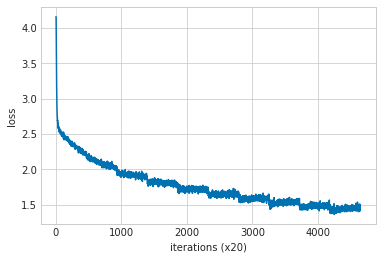

In [14]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [15]:
word_vecs = model.word_vecs

In [16]:
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = './cache/cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)